# NLP Dataset - IMDB-50K Movie Review Analysis

## Assignment Details

**Problem Statement:** 1 (IMDB-50K Movie Review Analysis)<br>
**Question:** No.2. NLP Dataset<br>
**Group:** DL Assignment Groups 21<br>
**Group Members:**
* Harish Pasupuleti - 2019AP04028
* Sanket Walke - 2019AP04052
* Chitral Verma - 2019AP04012

### This notebook classifies movie reviews as positive or negative using the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

### Mounting Google drive to load source data

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries/dataset

### a.	Import the required libraries and the dataset 

In [38]:
import pandas as pd
import numpy as np
import nltk
import re
from wordcloud import WordCloud
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import Adam
from keras import regularizers
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True


###Load and Check Data

In [18]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [19]:
# Size of our data.
data.shape

(50000, 2)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [21]:
# statistical summary of our data
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


### b. Check GPU availability

In [22]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
print("GPU device name:", tf.test.gpu_device_name())

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available
GPU device name: /device:GPU:0


## 2.	Data Visualization and augmentation 

In [23]:
#browsing the data
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### a.	Print at least two movie reviews from each class

In [24]:
data[data['sentiment']=='positive'].head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [25]:
data[data['sentiment']=='negative'].head(2)

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative


### b.	Plot a bar graph of class distribution 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


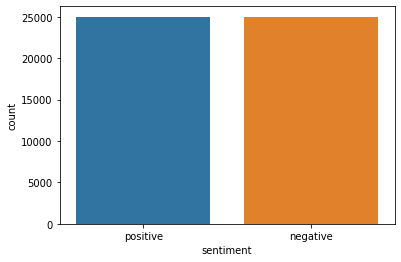

negative    25000
positive    25000
Name: sentiment, dtype: int64


In [26]:
sns.countplot(data['sentiment'])
plt.show()
print(data.sentiment.value_counts())

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We see that the number of positive and negative comments is equal. </p> </li>
</ul>

In [27]:
data.sentiment=[1 if sentiment=='positive' else 0 for sentiment in data.sentiment]

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > We convert our sentiment property to int values. </p> </li>
        <li  style = "color:green" > <p style = "color:black;font-weight:bold" > positive --> 1 </p> </li>
        <li  style = "color:red" > <p style = "color:black;font-weight:bold" > negative --> 0 </p> </li>
</ul>

In [28]:
print(data.sentiment.value_counts())

1    25000
0    25000
Name: sentiment, dtype: int64


<a id ='2' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0">Ineffective Words </h2>

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > Let's first take a look at the ineffective English words. </p> </li>
</ul>

In [29]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [30]:
WPT= nltk.WordPunctTokenizer()
stop_words_list=nltk.corpus.stopwords.words('english')

In [31]:
print(stop_words_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<a id ='3' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0">Clearing data </h2>

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > process of clearing punctuation marks in data. </p> </li>
     <li  style = "color:green" > <p style = "color:black;font-weight:bold" > cleaning unnecessary marks in data. </p> </li>
        <li  style = "color:red" > <p style = "color:black;font-weight:bold" > capitalization to lowercase. </p> </li>
     <li  style = "color:green" > <p style = "color:black;font-weight:bold" > cleaning extra spaces. </p> </li>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > removal of stopwords in sentences. </p> </li>
</ul>

In [32]:
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

data['review'] = data['review'].apply(lambda x: x.lower())

data['review'] = data['review'].apply(lambda x: x.strip())

In [33]:
data.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the ...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1
5,probably my all time favorite movie a story of...,1
6,i sure would like to see a resurrection of a u...,1
7,this show was an amazing fresh innovative id...,0
8,encouraged by the positive comments about this...,0
9,if you like original gut wrenching laughter yo...,1


In [34]:
"""
I closed the stopword process because it took a long time.
If you want, you can try opening the codes in the comment line.
"""
# def token(values):
#    words = nltk.tokenize.word_tokenize(values)
#    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
#    not_stopword_doc = " ".join(filtered_words)
#    return not_stopword_doc
# data['review'] = data['review'].apply(lambda x: token(x))

'\nI closed the stopword process because it took a long time.\nIf you want, you can try opening the codes in the comment line.\n'

### c. Other Visualizations 

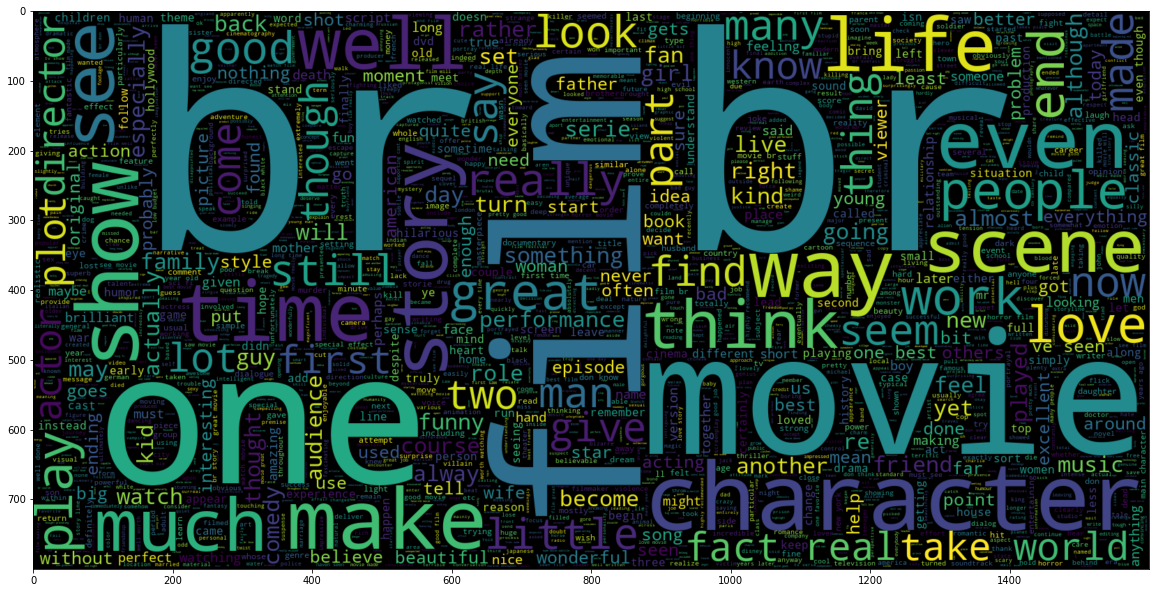

In [36]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

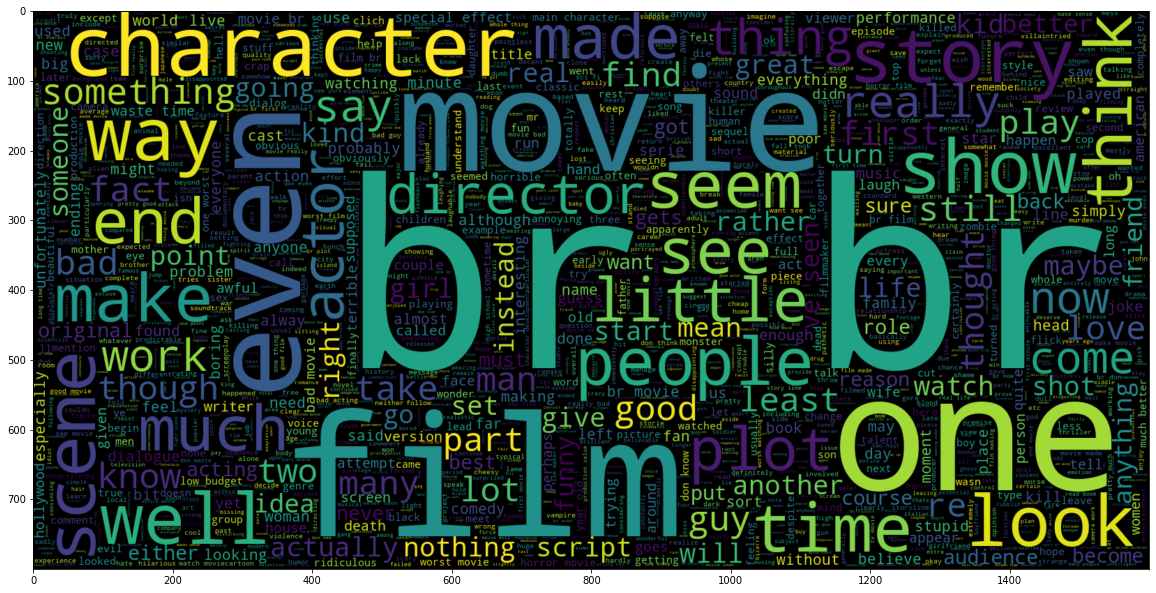

In [37]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

<a id ='4' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Train - Test Split </h2>

In [ ]:
sentiment=data.sentiment.values
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
data=data['review']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(data,sentiment,test_size=0.2)

### d. Shapes of train and test data

In [ ]:
print('Train set size:',x_train.shape)
print('Test set size:', x_test.shape)

Train set size: (40000,)
Test set size: (10000,)


## 3.	Data Pre-processing 

### a. Handling string data

<a id ='5' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Creating a Dictionary </h2>

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We create a dictionary of 15000 most used words in English for later use. </p> </li>
</ul>

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
tokenizer= Tokenizer(num_words=15000)
tokenizer.fit_on_texts(data)

In [ ]:
print(tokenizer.word_index)

Output hidden; open in https://colab.research.google.com to view.

<a id ='6' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Bring the comments to the same size </h2>

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > comments of different lengths cannot train the model. That's why we need to make the sentences the same size. </p> </li>
</ul>

In [ ]:
x_train_token= tokenizer.texts_to_sequences(x_train)
x_test_token= tokenizer.texts_to_sequences(x_test)

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" >We replace the words in our sentences with whichever index they are included in the dictionary we have created above. </p> </li>
</ul>

In [ ]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens=[len(num) for num in x_train_token+x_test_token]
num_tokens=np.array(num_tokens)

In [ ]:
num_tokens

array([176, 158, 250, ..., 136, 191, 386])

In [ ]:
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)
max_tokens

567

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > max_tokens : This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average. </p> </li>
</ul>

In [ ]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens<max_tokens)/len(num_tokens)

0.94524

### b. Using a pre training embedded layer from Tensorflow hub.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
#hub_layer(x_train[:3])

### c.	Bring the train and test data in the required format.

In [ ]:
#data is adjusted according to the number of tokens specified
x_train_pad = pad_sequences(x_train_token, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_token, maxlen=max_tokens)

In [ ]:
x_train_pad.shape
x_test_pad.shape

(40000, 567)

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > As you can see, we have set it to shape 567. So max_tokens
 </p> </li>
</ul>

In [ ]:
idx=tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
print(inverse_map)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def return_to_sentence(tokens):
  words= [inverse_map[token] for token in tokens if token!=0]
  text=' '.join(words)
  return text

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > We write a function to revert the sentences that we have made int.
 </p> </li>
</ul>

In [ ]:
#normal comment
print(return_to_sentence(x_train_pad[215]))

i caught this movie on my local movie channel and i rather enjoyed watching the film it has all the elements of a good teen film and more this film aside from dealing with boys girls relationships and sex and the like also deals with the issue of use by young people br br the film has that real life feel to it no loud music no special effects and no outrageous scenes which for this movie was right that feel makes it easy to relate to the characters in the film some of which we probably know from where we live br br overall a good movie fun to watch br br


In [ ]:
#token equivalent of comment
print(x_train_pad[215])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
# model=Sequential()

# embedding_size=50

# model.add(Embedding(input_dim=15000, output_dim=embedding_size,input_length=max_tokens,name='Embedding_Layer' ))

# #model.add(LSTM(units=16,return_sequences=True))
# model.add(Dense(units=16,activation='relu'))
# model.add(Dropout(0.1))

# #model.add(LSTM(units=8, return_sequences=True))
# model.add(Dense(units=8,activation='relu'))
# model.add(Dropout(0.1))

# #model.add(LSTM(units=4))
# model.add(Dense(units=4,activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(1, activation='sigmoid'))

# optimizer=Adam(lr=1e-3)

# model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

## Model Building

  #### a.	Sequential Model layers- Use AT LEAST 3 hidden     layers with appropriate input for each. Choose the best number for hidden units and give reasons.

  #### b.	Add L2 regularization to all the layers.

  #### c.	Add one layer of dropout at the appropriate position and give reasons.

### d.	Choose the appropriate activation function for all the layers

In [ ]:

model = tf.keras.Sequential()
model.add(hub_layer)

model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(1))



### e.	Print the model summary.

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 124,643,729
Trainable params: 124,643,729
Non-trainable params: 0
_________________________________________________________________


## 5. Model Compilation

### a.	Compile the model with the appropriate loss function.

### b.	Use an appropriate optimizer.

### c.	Use accuracy as a metric.

In [ ]:
# ----- Compile model -----

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])

#model.compile(optimizer='adam',
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

## 6.	Model Training 

#### a.	Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

In [ ]:
start = time.time()

In [ ]:
history=model.fit(x_train,y_train,validation_split=0.3, epochs=10, batch_size=1000, shuffle=True, verbose=1)

Epoch 1/10
28/28 [==============================] - 4s 137ms/step - loss: 7.8922 - accuracy: 0.4978 - val_loss: 7.9095 - val_accuracy: 0.4964
Epoch 2/10
28/28 [==============================] - 4s 132ms/step - loss: 7.8223 - accuracy: 0.5020 - val_loss: 7.9038 - val_accuracy: 0.4964
Epoch 3/10
28/28 [==============================] - 4s 134ms/step - loss: 7.7855 - accuracy: 0.5040 - val_loss: 7.8984 - val_accuracy: 0.4964
Epoch 4/10
28/28 [==============================] - 4s 132ms/step - loss: 7.8163 - accuracy: 0.5017 - val_loss: 7.8932 - val_accuracy: 0.4964
Epoch 5/10
28/28 [==============================] - 4s 132ms/step - loss: 7.7241 - accuracy: 0.5073 - val_loss: 7.8881 - val_accuracy: 0.4964
Epoch 6/10
28/28 [==============================] - 4s 131ms/step - loss: 7.8099 - accuracy: 0.5014 - val_loss: 7.8833 - val_accuracy: 0.4964
Epoch 7/10
28/28 [==============================] - 4s 131ms/step - loss: 7.8308 - accuracy: 0.4997 - val_loss: 7.8787 - val_accuracy: 0.4964
Epoch 

#### b.	Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [ ]:
# Print the total time taken for training
print("Total time taken for training: ", time.time() - start, "seconds")

<a id ='9' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Visualization (Acc - Loss)</h2>

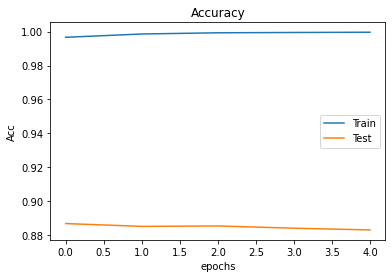

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

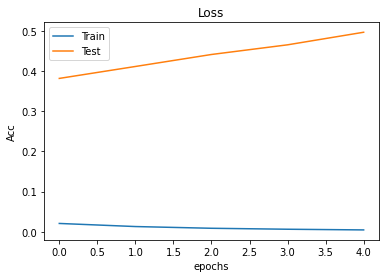

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## Model Evaluation

#### a.	Print the final train and validation loss and accuracy

In [ ]:
testLoss, testAccuracy = model2.evaluate(x_test,y_test)

# Print the final test/validation loss and accuracy.
print('Final testing loss \t', testLoss)
print('Final testing accuracy ', testAccuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.5095 - accuracy: 0.8574


<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Evaluate the model </h2>

In [ ]:
probabilities = model.predict(x_test)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

 
Results
Accuracy: 0.4990
 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4990
           1       0.00      0.00      0.00      5010

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Version 2 of the model with different hyperparameters </h2>

<a id ='7' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Create Model </h2>

In [ ]:
embedding_size=50
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=15000, output_dim=embedding_size, input_length=max_tokens))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))

# ----- Compile model -----
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])
#model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 567, 50)           750000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 567, 50)           0         
_________________________________________________________________
global_average_pooling1d_5 ( (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                

In [ ]:
history=model.fit(x_train_pad,y_train,validation_split=0.3, epochs=10, batch_size=500, shuffle=True, verbose=1)

Epoch 1/10
56/56 [==============================] - 3s 49ms/step - loss: 1.4670 - accuracy: 0.4985 - val_loss: 1.4404 - val_accuracy: 0.5170
Epoch 2/10
56/56 [==============================] - 3s 46ms/step - loss: 1.4318 - accuracy: 0.5176 - val_loss: 1.4065 - val_accuracy: 0.6072
Epoch 3/10
56/56 [==============================] - 3s 46ms/step - loss: 1.3985 - accuracy: 0.5415 - val_loss: 1.3742 - val_accuracy: 0.6378
Epoch 4/10
56/56 [==============================] - 3s 46ms/step - loss: 1.3664 - accuracy: 0.5611 - val_loss: 1.3429 - val_accuracy: 0.6036
Epoch 5/10
56/56 [==============================] - 3s 46ms/step - loss: 1.3355 - accuracy: 0.5741 - val_loss: 1.3132 - val_accuracy: 0.6727
Epoch 6/10
56/56 [==============================] - 3s 45ms/step - loss: 1.3059 - accuracy: 0.5938 - val_loss: 1.2848 - val_accuracy: 0.7548
Epoch 7/10
56/56 [==============================] - 3s 47ms/step - loss: 1.2779 - accuracy: 0.6102 - val_loss: 1.2578 - val_accuracy: 0.7316
Epoch 8/10
56

<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Result </h2>

In [ ]:
result= model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1842 - accuracy: 0.7450


<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Evaluate the model </h2>

In [ ]:
probabilities = model.predict(x_test_pad)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

 
Results
Accuracy: 0.7450
 
              precision    recall  f1-score   support

           0       0.81      0.64      0.71      4963
           1       0.71      0.85      0.77      5037

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000



<a id ='9' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Visualization (Acc - Loss)</h2>

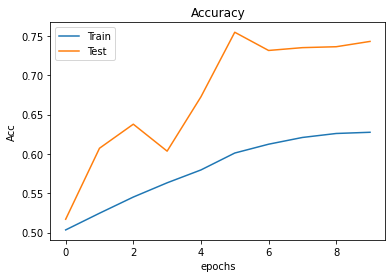

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

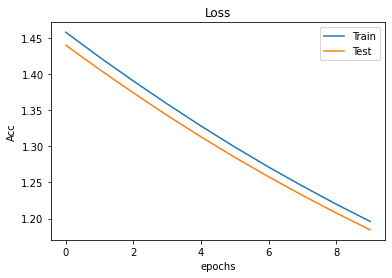

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Version 3 of the model with different hyperparameters </h2>

<a id ='7' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Create Model </h2>

In [ ]:
embedding_size=50
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=15000, output_dim=embedding_size, input_length=max_tokens))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))

# ----- Compile model -----
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])
#model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history=model.fit(x_train_pad,y_train,validation_split=0.3, epochs=10, batch_size=500, shuffle=True, verbose=1)

<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Result </h2>

In [ ]:
result= model.evaluate(x_test_pad, y_test)

<a id ='8' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Evaluate the model </h2>

In [ ]:
probabilities = model.predict(x_test_pad)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

<a id ='9' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Visualization (Acc - Loss)</h2>

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()